# 0. Установка библиотек

In [ ]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [ ]:
# pip install apimoex

In [ ]:
import requests
# import mplfinance as mpf
import apimoex
import pandas as pd
import talib as ta
from talib import abstract
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Задание 1.
Построить линейный график цен акций ПАО «Сбербанк» (SBER) за последний год, период – 1 день. Добавить простую (SMA) и экспоненциальную (EMA) скользящую среднюю с окном сглаживания 𝑛 = 21 день по ценам закрытия (Close). Установить зеленый цвет для SMA, красный – EMA. В качестве ответа привести таблицу с указананием дат пересечения индикаторов на графике. Указание. Использовать apimoex.

## 1.1. Загрузка и обработка данных

In [ ]:

def get_quotes(ticker, interval, date_start=datetime.date.today() - datetime.timedelta(days=365), date_finish=datetime.date.today()):

  """
  Функция для загрузки котировок ценных бумаг. Принимает в качестве аргументов тикер акции и таймфрейм:
  1m : 1, 10m : 10, 60m : 60, 1d : 24, 1w : 7, 1m : 31, 1y : 4
  Период датасета по умолчанию: последние 365 дней.
  """

  url = f'http://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/candles.json?from={date_start}&till={date_finish}&interval={interval}'
  j = requests.get(url).json()
  data = [{k: r[i] for i, k in enumerate(j['candles']['columns'])} for r in j['candles']['data']]
  df = pd.DataFrame(data, columns=["open", "close", "high", "low", "value", "volume", "begin"])
  df["Date"] = pd.to_datetime(df["begin"])
  df.drop("begin", axis = 1, inplace = True)
  df = df.reset_index(drop=True) # метод сбрасывает индекс DataFrame и заменяет его на обычный индекс, состоящий из целых чисел
  return df[["Date", "open", "close", "high", "low", "value", "volume"]]

In [ ]:
sber = get_quotes("SBER", 24)

sber["sma"] = ta.abstract.SMA(sber, timeperiod = 21)
sber["ema"] = ta.abstract.EMA(sber, timeperiod = 21)

,Date,open,close,high,low,value,volume,sma,ema
0,2022-10-27,124.75,126.61,127.50,123.68,1.109907e+10,87915140,NaN,NaN
1,2022-10-28,126.14,126.97,127.25,124.60,9.289877e+09,73660000,NaN,NaN
2,2022-10-31,127.20,126.72,128.60,125.41,7.705149e+09,60762870,NaN,NaN
3,2022-11-01,127.20,127.05,127.97,126.12,4.678425e+09,36820880,NaN,NaN
4,2022-11-02,127.06,125.49,127.74,123.75,5.091797e+09,40216620,NaN,NaN
...,...,...,...,...,...,...,...,...,...
250,2023-10-23,270.45,270.10,274.10,269.65,1.698429e+10,62432160,262.597619,264.193403
251,2023-10-24,270.00,271.27,272.06,268.62,7.588324e+09,28029860,263.484286,264.836730
252,2023-10-25,271.50,273.73,274.96,270.53,1.141537e+10,41830970,264.334762,265.645209
253,2023-10-26,274.11,269.90,276.00,269.12,1.622554e+10,59497750,264.991905,266.032008


### 1.2 Построение графика

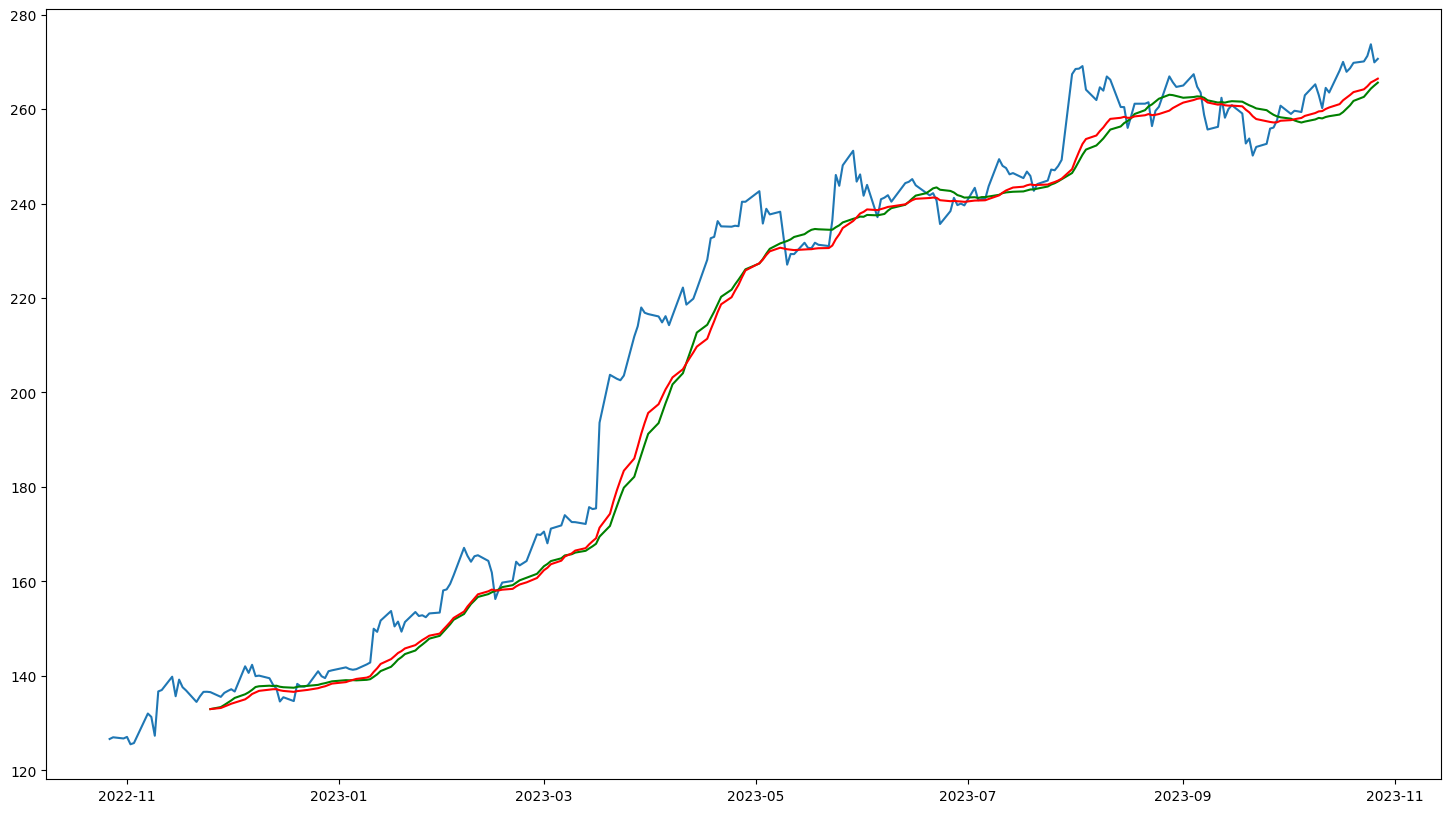

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(sber.Date, sber.close)
plt.plot(sber.Date, sber.sma, color = "g")
plt.plot(sber.Date, sber.ema, color = "r")

plt.show()

## 1.3. Точки пересечения

In [ ]:
def sign(x):
  if x < 0:
    return -1
  elif x > 0:
    return 1
  else:
    return 0

delta_list = []
for i in range(len(sber.index)):
  delta = sber.sma[i] - sber.ema[i]
  delta_list.append(delta)

indexes = []
for j in range(len(delta_list)-1):
  if sign(delta_list[j+1]) != sign(delta_list[j]):
    indexes.append(j+1)

intersection_dates = []
for index in indexes:
  intersection_dates.append(sber.Date[index])

print(pd.Series(intersection_dates))

0    2022-11-28
1    2023-01-05
2    2023-02-16
3    2023-03-09
4    2023-04-11
5    2023-05-02
6    2023-05-03
7    2023-05-30
8    2023-06-14
9    2023-07-11
10   2023-08-18
11   2023-10-03
dtype: datetime64[ns]


# Задание 2.
Для временного ряда цен закрытия (Close) ПАО «Сбербанк» (SBER)
построить технические индикаторы – индекс относительной силы RSI(14,
20, 80) и полосу Болинжера BB(21, 2). Указание. Использовать
библиотеку TA-Lib.

2.1 Расчет технических индикаторов

In [ ]:
sber["rsi14"] = ta.abstract.RSI(sber.close, timeperiod = 14)
# sber["rsi20"] = ta.abstract.RSI(sber.close, timeperiod = 20)
# sber["rsi80"] = ta.abstract.RSI(sber.close, timeperiod = 80)
sber["upper_band"], sber["middle_band"], sber["lower_band"] = ta.abstract.BBANDS(sber.close, timeperiod = 21)

2.2 Построение графика

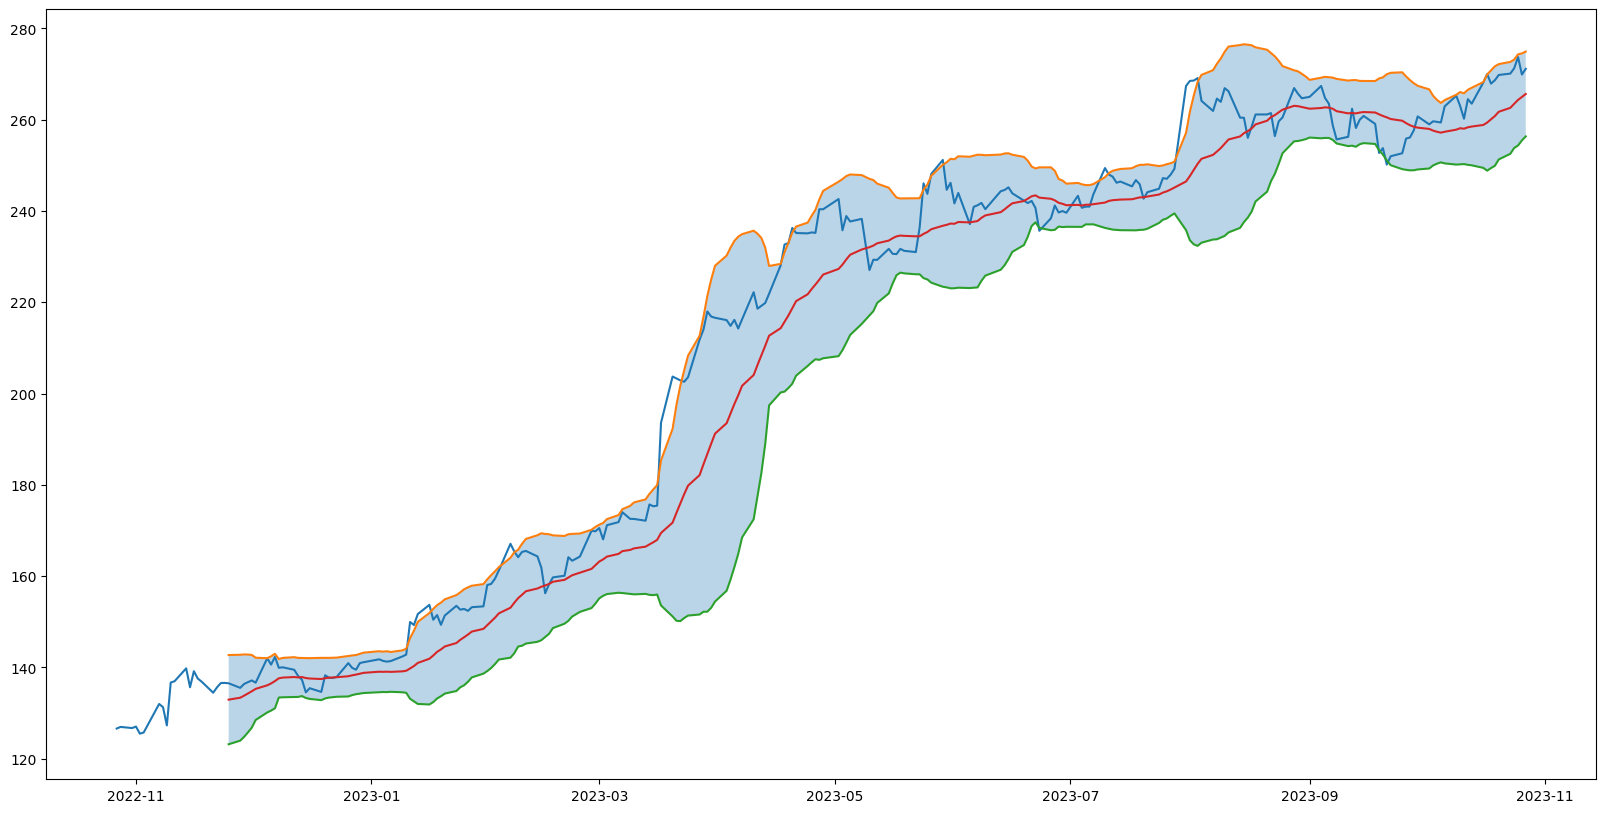

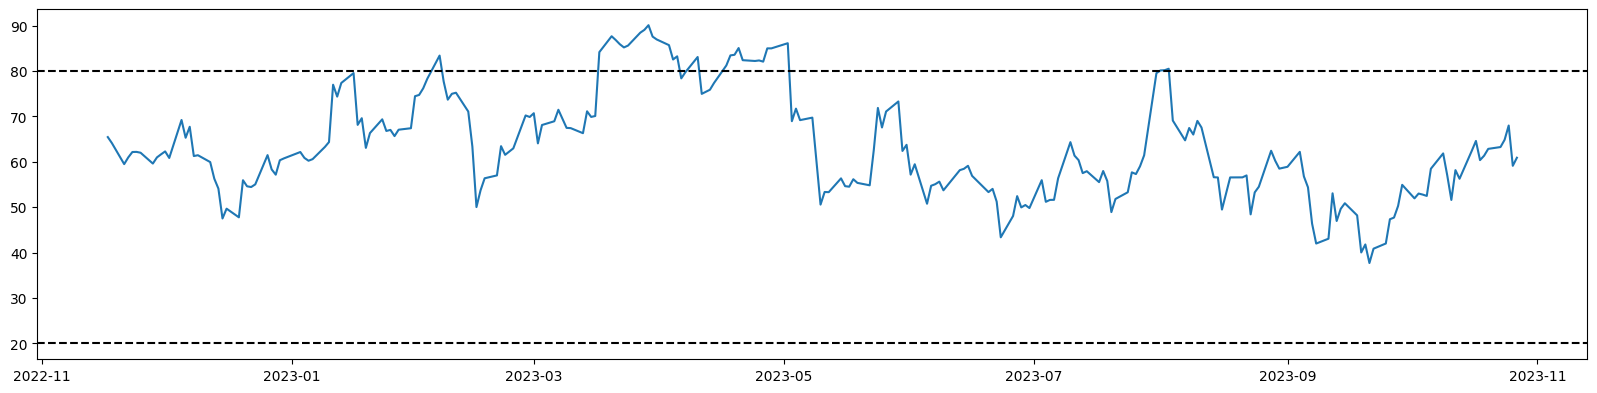

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(sber.Date, sber.close)
# полоса Боллинжера
plt.plot(sber.Date, sber.upper_band)
plt.plot(sber.Date, sber.lower_band)
plt.plot(sber.Date, sber.middle_band)
plt.fill_between(sber['Date'], sber.lower_band, sber.upper_band, alpha=0.3)
plt.show()
# RSI
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(sber.Date, sber.rsi14)
plt.axhline(y=20, color='black', linestyle='--')
plt.axhline(y=80, color='black', linestyle='--')
# plt.plot(sber.Date, sber.rsi20)
# plt.plot(sber.Date, sber.rsi80)
plt.show()

# Задание 3.
Вычислить максимальную просадку (maxDrawDown) для цен закрытия
(Close) ПАО «Сбербанк» (SBER).

In [ ]:
def maxDrawnDown(dataset, start_day = datetime.date.today() - datetime.timedelta(days=365)):
  dataset['CLOSE_cummax'] = dataset['close'].cummax()
  day, df = start_day, 0
  for index, row in dataset.iterrows():
    proportion = 100 - ((100 * row["close"]) / row["CLOSE_cummax"])
    if proportion > df:
      day, df = index, round(proportion, 2)
  print(f"Максимальная просадка составила {df} %")
  # return day, df

maxDrawnDown(sber)

Максимальная просадка составила 7.04 %


# Задание 4.
Наложить на свечной график метки свечного паттерна Marubozu
White/Back для цен акций Apple (AAPL) за последний год, период – 1
день. Сравнить с результатами на https://www.tradingview.com/. Провести
моделирование и проварьировать 𝜖 ∈ [0, 0.3] c шагом 0.05% от цены актива.
Построить график, сделать выводы. Указание. Использовать yfinance.

In [ ]:
import yfinance as yf

4.1 Построение графика

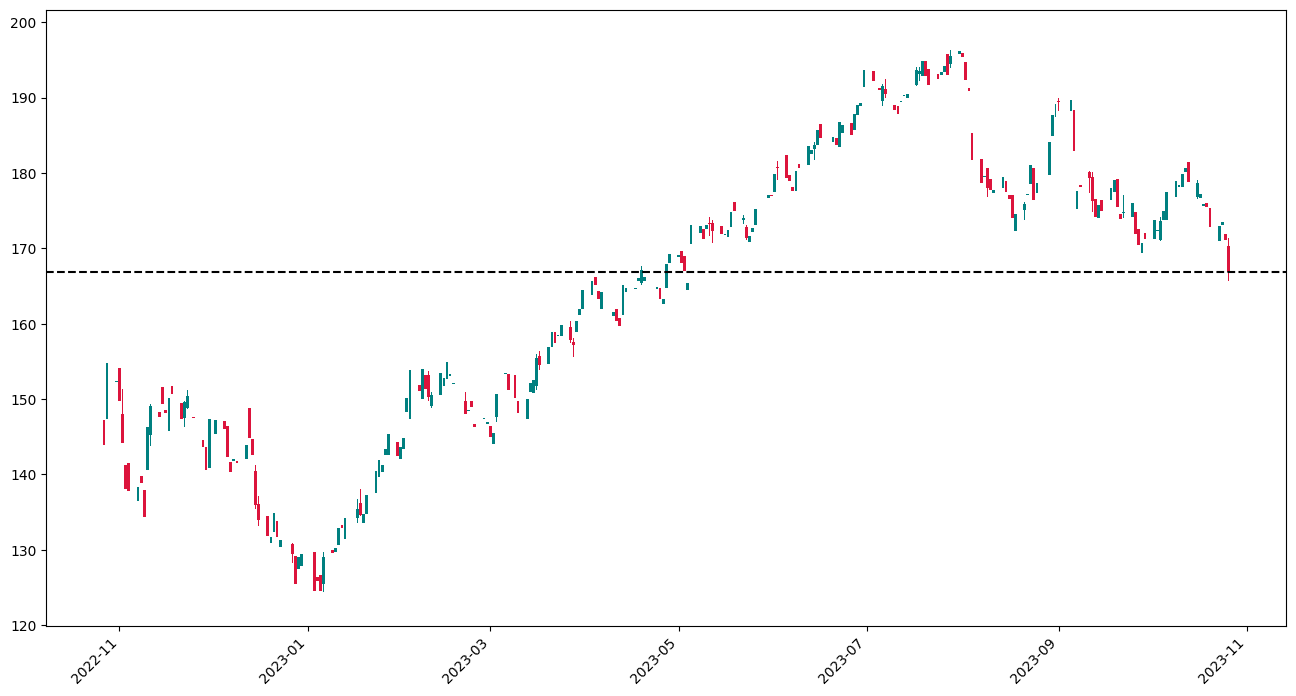

In [ ]:
apple=yf.Ticker("AAPL")
apple=apple.history(period="1y")

plt.figure(figsize=(16,8))

# ширина свеч и фетилей
width = 0.9
width2 = 0.05

up = apple[apple.Close>= apple.Open]
down = apple[apple.Close< apple.Open]

col1 = 'teal'
col2 = 'crimson'

#plot up prices
plt.bar(up.index, up.Close-up.Open, width, bottom=up.Open, color=col1)
plt.bar(up.index, up.High-up.Close, width2, bottom=up.Close, color=col1)
plt.bar(up.index, up.Low-up.Open, width2, bottom=up.Open, color=col1)

#plot down prices
plt.bar(down.index, down.Close-down.Open, width, bottom=down.Open, color=col2)
plt.bar(down.index, down.High-down.Open, width2, bottom=down.Open, color=col2)
plt.bar(down.index, down.Low-down.Close, width2, bottom=down.Close, color=col2)
plt.axhline(apple.Close[-1], color='black', linestyle='--', label = "LastClosePrice")
plt.xticks(rotation=45 , ha='right')

plt.show()

4.2 Проверка на правдоподобность

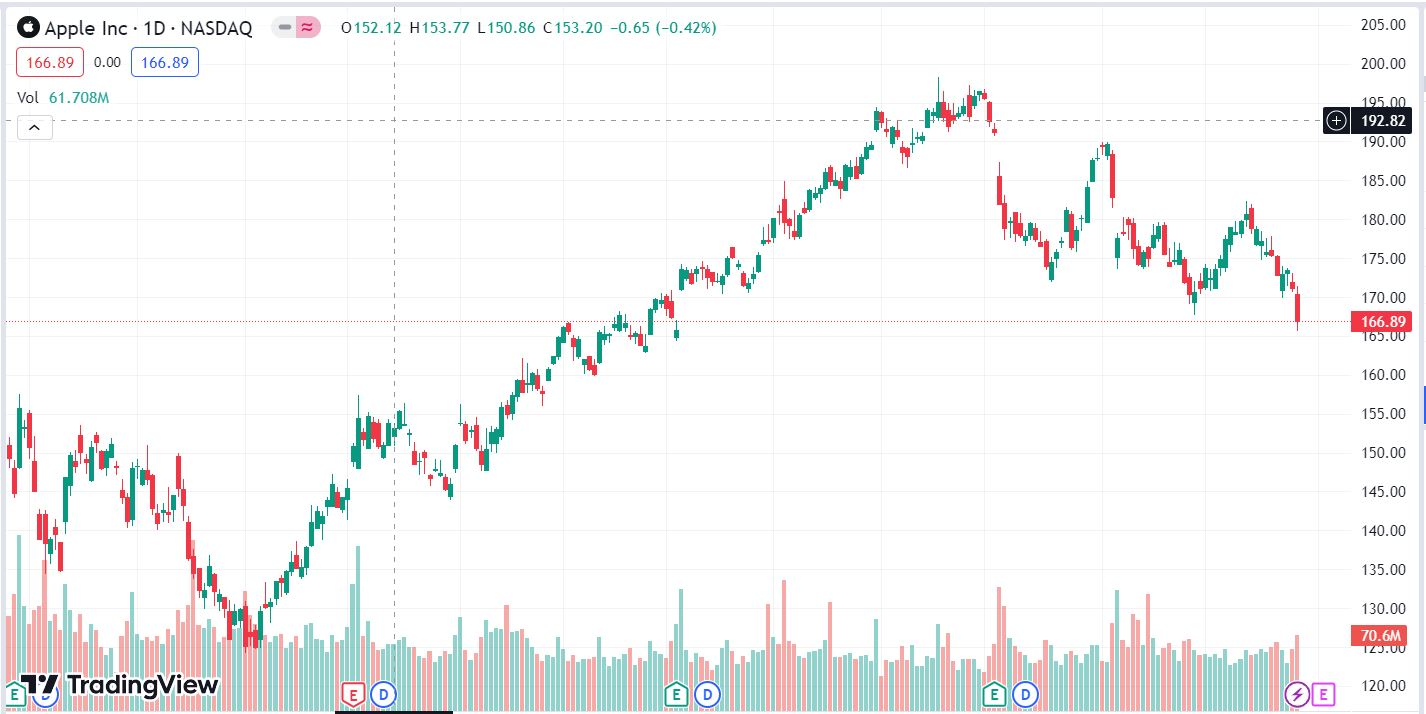

# Задание 5.
Провести проверку гипотезы о нормальности распределения
логарифмических доходностей для временного ряда котировок Apple
(AAPL) и Сбербанк (SBER) за последние 5 лет для периодов: 1 неделя и 1
месяц. Уровень значимости 0,95. Сравнить результаты, сделать выводы.
Указание. Использовать тест Шапиро-Уилка.

In [ ]:
import scipy

5.1 Загружаем данные

In [ ]:
date_start = datetime.date.today() - datetime.timedelta(days=1825)
date_finish = datetime.date.today()

sberCloseOneWeek = get_quotes("SBER", 7)
sberCloseOneMonth = get_quotes("SBER", 31)

appleCloseOneWeek = yf.download(
        'AAPL',
        start=f'{date_start}',
        end=f'{date_finish}',
        interval='1wk'
)
appleCloseOneWeek.drop(columns=['Adj Close'], inplace=True)
appleCloseOneWeek.columns = ['open', 'high', 'low', 'close', 'volume']

appleCloseOneMonth = yf.download(
        'AAPL',
        start=f'{date_start}',
        end=f'{date_finish}',
        interval='1mo'
)
appleCloseOneMonth.drop(columns=['Adj Close'], inplace=True)
appleCloseOneMonth.columns = ['open', 'high', 'low', 'close', 'volume']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


5.2 Расчет логарифмических доходностей

In [ ]:
def ln_profit(close):
    return np.log(close[1:] / close[:-1])

In [ ]:
data = [
    sberCloseOneWeek,
    sberCloseOneMonth,
    appleCloseOneWeek,
    appleCloseOneMonth
]
lnProfits = []
for i in data:
    lnProfits.append(ln_profit(np.array(i['close'])))

for i in lnProfits:
    stat, pvalue = scipy.stats.shapiro(i)
    if pvalue < 0.05:
        print('Распределение не нормальное, p-value:', pvalue)
    else:
        print('Распределение нормально, p-value: ', pvalue)
    # plt.figure(figsize=(20, 11))
    # plt.plot(i)
    # plt.show()

Распределение не нормальное, p-value: 0.03724369406700134
Распределение нормально, p-value:  0.17446108162403107
Распределение не нормальное, p-value: 7.046489918138832e-05
Распределение не нормальное, p-value: 0.031311746686697006
